<a href="https://colab.research.google.com/github/AkshitPareek/3D-reconstruction-of-an-object-from-a-Single-Image-and-a-Text-Prompt/blob/main/Reconstruction_on_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/facebookresearch/segment-anything.git

!git clone https://github.com/IDEA-Research/GroundingDINO.git

!git clone https://github.com/facebookresearch/MCC.git

Cloning into 'segment-anything'...
remote: Enumerating objects: 279, done.
remote: Counting objects: 100% (190/190), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 279 (delta 127), reused 116 (delta 116), pack-reused 89
Receiving objects: 100% (279/279), 18.31 MiB | 8.26 MiB/s, done.
Resolving deltas: 100% (139/139), done.
Cloning into 'GroundingDINO'...
remote: Enumerating objects: 278, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 278 (delta 22), reused 18 (delta 17), pack-reused 226
Receiving objects: 100% (278/278), 12.34 MiB | 16.76 MiB/s, done.
Resolving deltas: 100% (126/126), done.
Cloning into 'MCC'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (48/48), done.
remote: Total 52 (delta 14), reused 39 (delta 4), pack-reused 0
Unpacking objects: 100% (52/52), 11.23 MiB | 7.31 MiB/s, done.


In [2]:
!mv segment-anything SegmentAnything

In [3]:
! wget https://huggingface.co/ShilongLiu/GroundingDINO/resolve/main/groundingdino_swint_ogc.pth

! wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

! wget https://dl.fbaipublicfiles.com/MCC/co3dv2_all_categories.pth

--2023-04-27 20:38:13--  https://huggingface.co/ShilongLiu/GroundingDINO/resolve/main/groundingdino_swint_ogc.pth
Resolving huggingface.co (huggingface.co)... 18.155.68.38, 18.155.68.121, 18.155.68.116, ...
Connecting to huggingface.co (huggingface.co)|18.155.68.38|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/74/12/7412fdcd8b26caa1c47919c53fafeb25db279907c51c15d923d8526a874dd651/3b3ca2563c77c69f651d7bd133e97139c186df06231157a64c507099c52bc799?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27groundingdino_swint_ogc.pth%3B+filename%3D%22groundingdino_swint_ogc.pth%22%3B&Expires=1682887093&Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmNlIjoiaHR0cHM6Ly9jZG4tbGZzLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzc0LzEyLzc0MTJmZGNkOGIyNmNhYTFjNDc5MTljNTNmYWZlYjI1ZGIyNzk5MDdjNTFjMTVkOTIzZDg1MjZhODc0ZGQ2NTEvM2IzY2EyNTYzYzc3YzY5ZjY1MWQ3YmQxMzNlOTcxMzljMTg2ZGYwNjIzMTE1N2E2NGM1MDcwOTljNTJiYzc5OT9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSoiLCJ

In [4]:
!mkdir checkpoints

In [5]:
!mv /content/sam_vit_h_4b8939.pth /content/checkpoints/sam_vit_h_4b8939.pth

!mv /content/groundingdino_swint_ogc.pth /content/checkpoints/groundingdino_swint_ogc.pth

!mv /content/co3dv2_all_categories.pth /content/MCC/co3dv2_all_categories.pth

In [6]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith(("1.13.", "2.0.")) and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61429 sha256=9706e88d6243eed2312205713d72b8743601c757e7d8fb5054b9d1918b0cbb40
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31547 sha256=14a335fa81ab249830c6c947a5f9ca9ec4cc1b9c07e96c6ad274f345e2ea2986
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu118_pyt200/dow

In [7]:
!pip install h5py omegaconf submitit
!pip install -e GroundingDINO
!pip install -e SegmentAnything

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 19.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144573 sha256=19af667b0434eafefcf549c95f9c0182c84e982808c93a351cacaee866b1cd7f
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/GroundingDINO
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.9/200.9 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 66.0 MB/s eta 0:00:00
  Running setup.py develop for groundingdino
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/SegmentAnything
  Preparing metadata (setup.py) ... done
  Running setup.py develop for segment-anything


In [8]:
!mkdir input
!mkdir output

In [9]:
IMAGE_NAME = "cup.jpeg"
TEXT_PROMPT = "cup"

In [10]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), "GroundingDINO"))
sys.path.append(os.path.join(os.getcwd(), "SegmentAnything"))
sys.path.append(os.path.join(os.getcwd(), "MCC"))

In [12]:

import argparse
import copy

import numpy as np
import torch
from PIL import Image, ImageDraw, ImageFont
from torchvision.ops import box_convert

# Grounding DINO
import GroundingDINO.groundingdino.datasets.transforms as T
from GroundingDINO.groundingdino.models import build_model
from GroundingDINO.groundingdino.util import box_ops
from GroundingDINO.groundingdino.util.slconfig import SLConfig
from GroundingDINO.groundingdino.util.utils import clean_state_dict, get_phrases_from_posmap
from GroundingDINO.groundingdino.util.inference import load_model, load_image, predict, annotate

import supervision as sv

# segment anything
from SegmentAnything.segment_anything import build_sam, SamPredictor 
import cv2
import numpy as np
import matplotlib.pyplot as plt


#MCC

from tqdm import tqdm

from pytorch3d.io.obj_io import load_obj

import MCC.main_mcc as main_mcc
import MCC.mcc_model as mcc_model
import MCC.util.misc as misc
from MCC.engine_mcc import prepare_data, generate_html

In [13]:
#Create the COnfig and Pre-Trained Weight path for GroundingDINO
CONFIG_PATH = os.path.join(os.getcwd(), "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py")
print(CONFIG_PATH, "; exist:", os.path.isfile(CONFIG_PATH))

WEIGHTS_NAME = "groundingdino_swint_ogc.pth"
WEIGHTS_PATH = os.path.join(os.getcwd(), "checkpoints", WEIGHTS_NAME)
print(WEIGHTS_PATH, "; exist:", os.path.isfile(WEIGHTS_PATH))

/content/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True
/content/checkpoints/groundingdino_swint_ogc.pth ; exist: True


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
#loading GroundingDINO
model = load_model(CONFIG_PATH, WEIGHTS_PATH)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
#loading SAM

sam_checkpoint = 'checkpoints/sam_vit_h_4b8939.pth'
sam = build_sam(checkpoint=sam_checkpoint)
sam.to(device=device)
sam_predictor = SamPredictor(sam)

IMAGE LOADING

In [18]:
# IMAGE_NAME = "dog.png"
IMAGE_PATH = os.path.join(os.getcwd(), "input", IMAGE_NAME)

bgr = cv2.imread(IMAGE_PATH)
rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

Classification

In [19]:
#running GroundingDINO

'''
This Piece of codes selects the object from a text prompt, and generates BoundingBox for SAM
'''

# TEXT_PROMPT = "dog"
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

image_source, image = load_image(IMAGE_PATH)

boxes, logits, phrases = predict(
    model=model, 
    image=image, 
    caption=TEXT_PROMPT, 
    box_threshold=BOX_TRESHOLD, 
    text_threshold=TEXT_TRESHOLD
)

annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)
annotated_frame = annotated_frame[...,::-1] # BGR to RGB

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:862: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


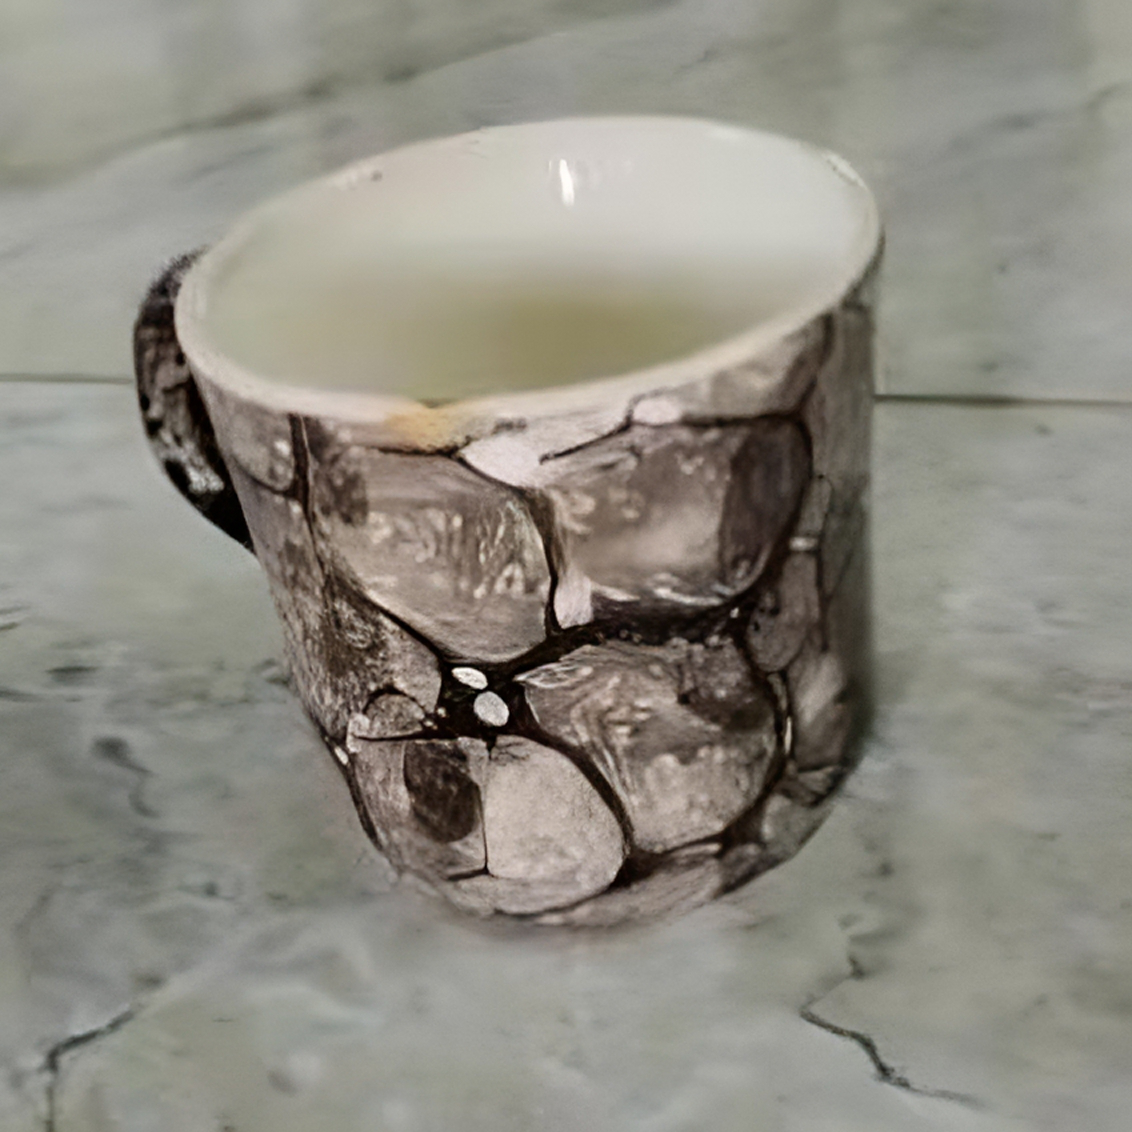

In [20]:
Image.fromarray(image_source)

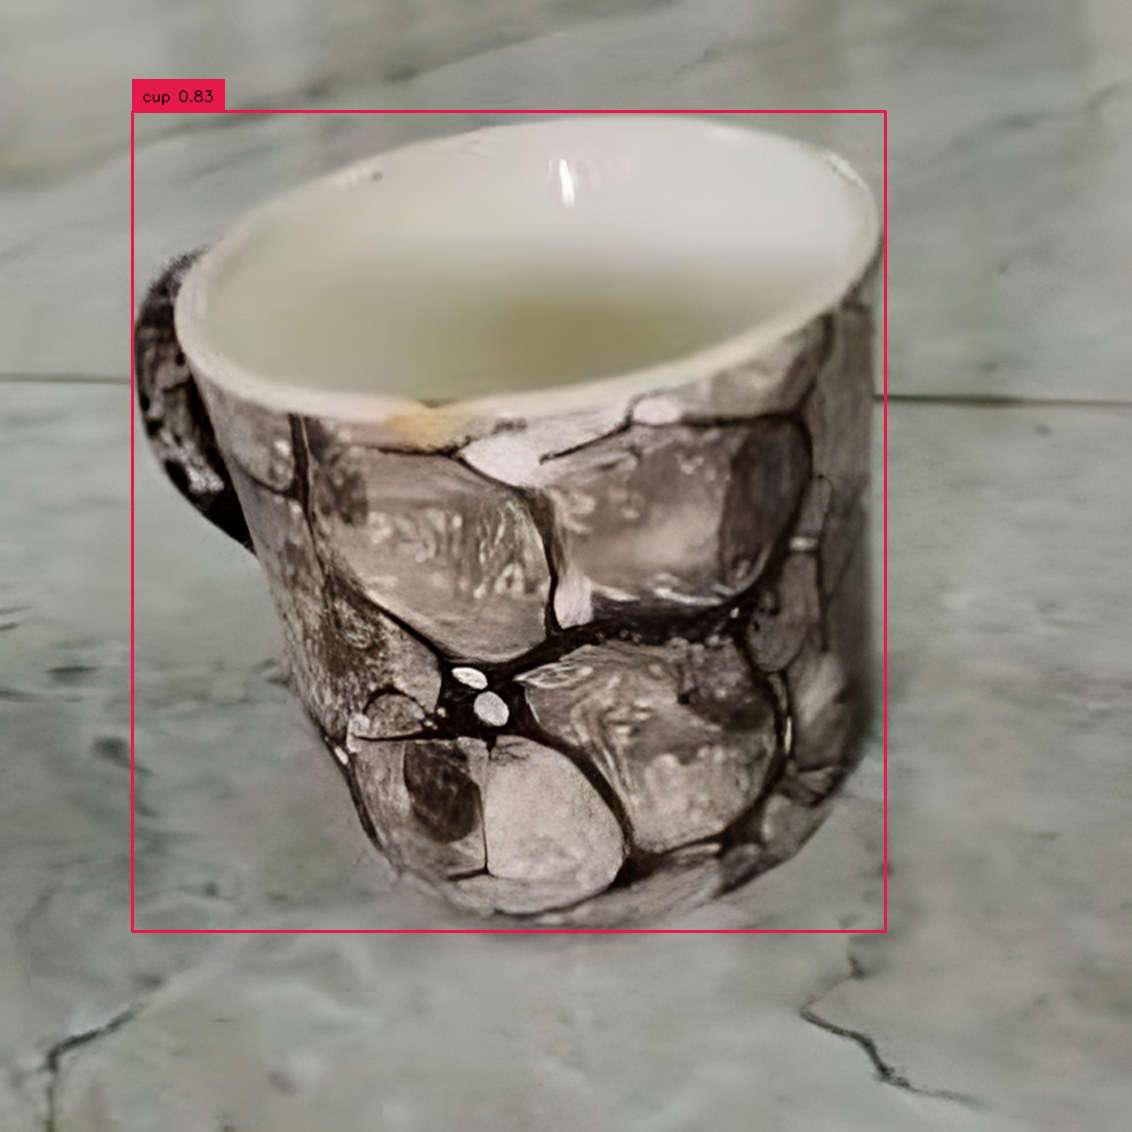

In [21]:
Image.fromarray(annotated_frame)

SEGMENTATION

In [22]:
sam_predictor.set_image(image_source)

In [23]:
H, W, _ = image_source.shape
boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])

In [24]:
transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_xyxy, image_source.shape[:2]).to(device)
masks, _, _ = sam_predictor.predict_torch(
            point_coords = None,
            point_labels = None,
            boxes = transformed_boxes,
            multimask_output = False,
        )

In [25]:
#function to display the mask 

def show_mask(mask, image, random_color=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    
    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image.cpu().numpy() * 255).astype(np.uint8)).convert("RGBA")

    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))

In [27]:
annotated_frame_with_mask = show_mask(masks[0][0].cpu(), annotated_frame)


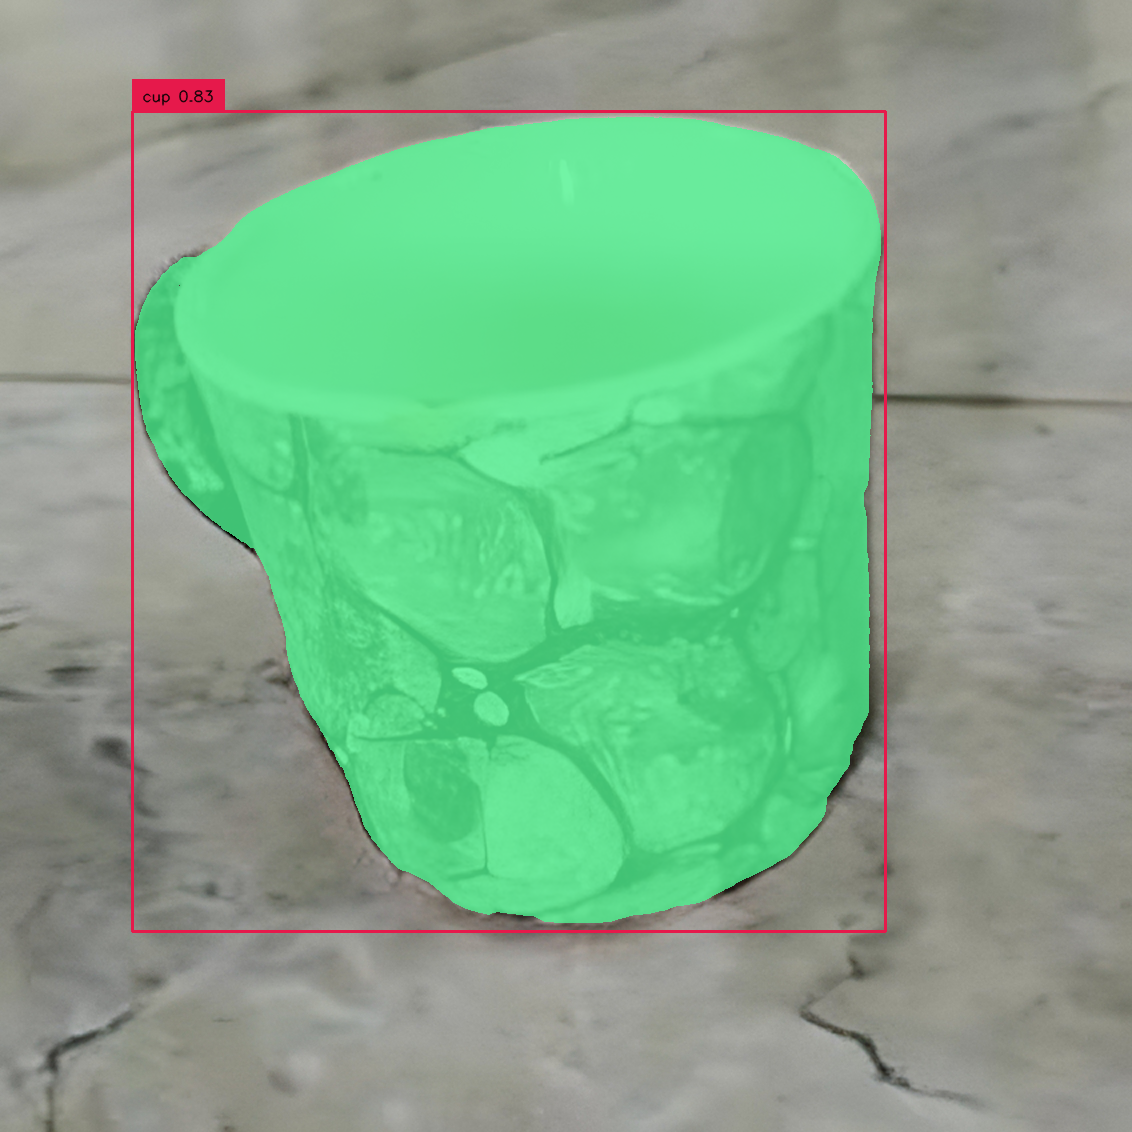

In [28]:
Image.fromarray(annotated_frame_with_mask)


Save Mask

In [29]:
image_mask_pil = Image.fromarray(masks[0][0].cpu().numpy())

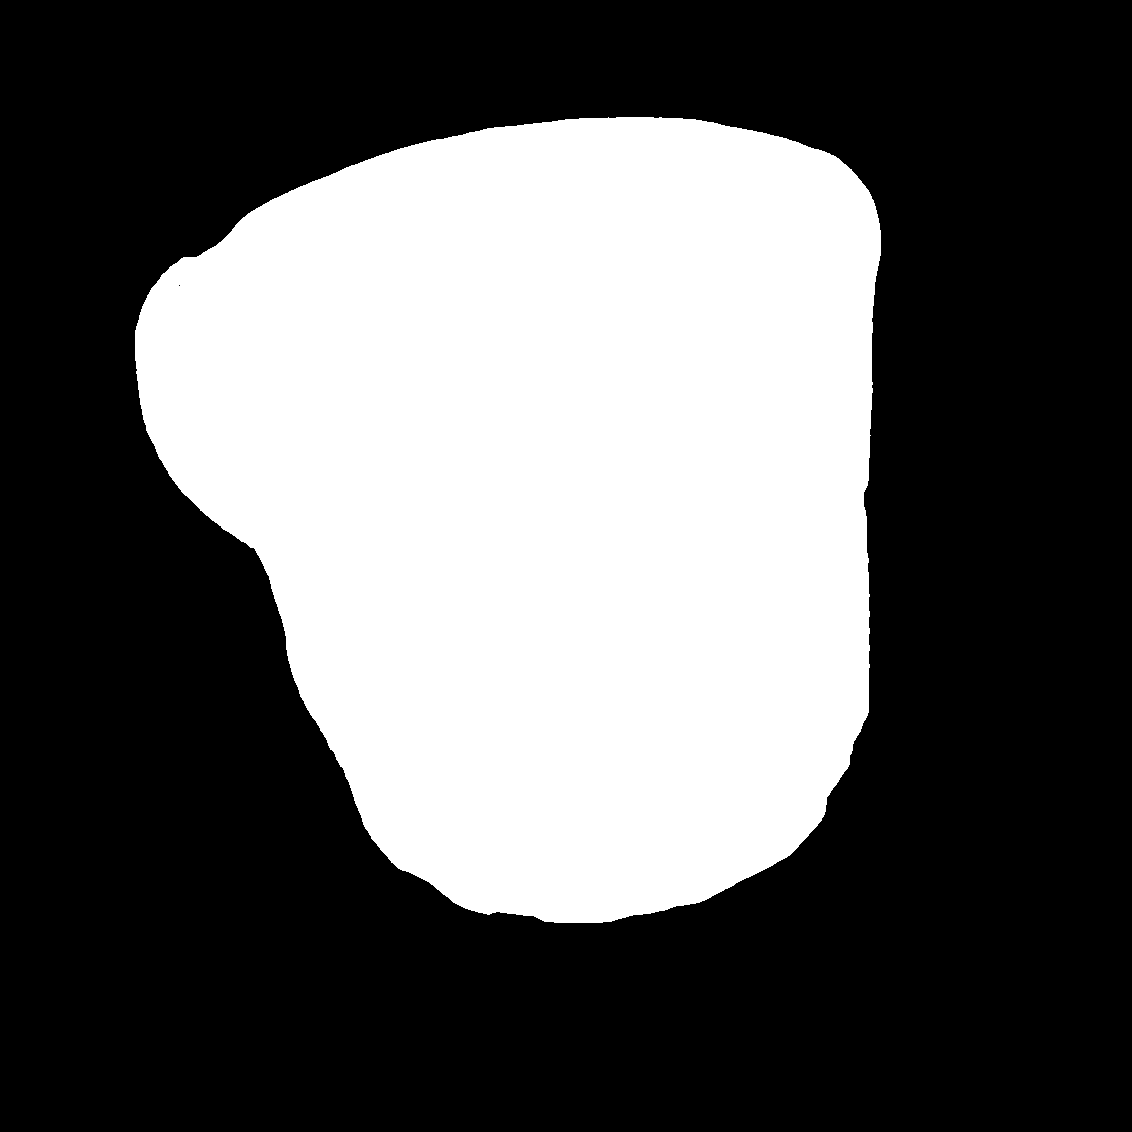

In [30]:
image_mask_pil

In [31]:
output_folder = os.path.join(os.getcwd(), "output/obj_masks")
filename = f"{os.path.splitext(IMAGE_NAME)[0]}_seg.png"

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Save the mask as a .png file
image_mask_pil.save(f"{output_folder}/{filename}")

In [32]:
mask_path = os.path.join(output_folder, filename)
print(mask_path)

/content/output/obj_masks/cup_seg.png


DEPTH

In [33]:
# seen in this context means the points that are visible in the image
s_rgb = (torch.tensor(bgr).float() / 255)[..., [2, 1, 0]]
H, W = s_rgb.shape[:2]
s_rgb = torch.nn.functional.interpolate(
    s_rgb.permute(2, 0, 1)[None],
    size=[H, W],
    mode="bilinear",
    align_corners=False,
)[0].permute(1, 2, 0)

In [34]:
# torch.hub.help("intel-isl/MiDaS", "DPT_BEiT_L_384", force_reload=True)  # Triggers fresh download of MiDaS repo

In [35]:
#load ZoeDepth and generate depth map

depth_model = torch.hub.load('isl-org/ZoeDepth', "ZoeD_N", pretrained=True).to("cuda").eval()
depth = depth_model.infer(s_rgb.permute(2, 0, 1)[None].cuda())
depth = depth[0].permute(1, 2, 0)
depth = depth.cpu().detach().numpy().squeeze()

/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/isl-org/ZoeDepth/zipball/main" to /root/.cache/torch/hub/main.zip


img_size [384, 512]


Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt


Downloading: "https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt" to /root/.cache/torch/hub/checkpoints/ZoeD_M12_N.pt
100%|██████████| 1.34G/1.34G [00:50<00:00, 28.5MB/s]


Loaded successfully


PROJECT DEPTH MAP TO POINT CLOUD

In [36]:
def get_intrinsics(H,W):
    """
    Intrinsics for a pinhole camera model.
    Assume fov of 55 degrees and central principal point.
    """
    f = 0.5 * W / np.tan(0.5 * 55 * np.pi / 180.0)
    cx = 0.5 * W
    cy = 0.5 * H
    return np.array([[f, 0, cx],
                     [0, f, cy],
                     [0, 0, 1]])


def backproject_depth_to_pointcloud(depth, rotation=np.eye(3), translation=np.zeros(3)):
    intrinsics = get_intrinsics(depth.shape[0], depth.shape[1])
    # Get the depth map shape
    height, width = depth.shape

    # Create a matrix of pixel coordinates
    u, v = np.meshgrid(np.arange(width), np.arange(height))
    uv_homogeneous = np.stack((u, v, np.ones_like(u)), axis=-1).reshape(-1, 3)

    # Invert the intrinsic matrix
    inv_intrinsics = np.linalg.inv(intrinsics)

    # Convert depth to the camera coordinate system
    points_cam_homogeneous = np.dot(uv_homogeneous, inv_intrinsics.T) * depth.flatten()[:, np.newaxis]

    # Convert to 3D homogeneous coordinates
    points_cam_homogeneous = np.concatenate((points_cam_homogeneous, np.ones((len(points_cam_homogeneous), 1))), axis=1)

    # Apply the rotation and translation to get the 3D point cloud in the world coordinate system
    extrinsics = np.hstack((rotation, translation[:, np.newaxis]))
    pointcloud = np.dot(points_cam_homogeneous, extrinsics.T)

    # Reshape the point cloud back to the original depth map shape
    pointcloud = pointcloud[:, :3].reshape(height, width, 3)

    return pointcloud


def save_point_cloud_to_obj(point_cloud, output_file):
    with open(output_file, 'w') as f:
        for y in range(point_cloud.shape[0]):
            for x in range(point_cloud.shape[1]):
                point = point_cloud[y, x]
                f.write(f'v {point[0]} {point[1]} {point[2]}\n')
                
                
def read_depth_map_from_png(png_file):
    depth_map = cv2.imread(png_file, cv2.IMREAD_UNCHANGED)
    depth_map = depth_map.astype(np.float32)
    return depth_map

In [37]:
point_cloud = backproject_depth_to_pointcloud(depth)

op_folder = os.path.join(os.getcwd(), "output/pcd_objects")
op_filename = f"{os.path.splitext(IMAGE_NAME)[0]}.obj"

if not os.path.exists(op_folder):
    os.makedirs(op_folder)
    
output_file = f"{op_folder}/{op_filename}"

save_point_cloud_to_obj(point_cloud, output_file)

In [38]:
def point_cloud_to_depth_map(point_cloud, img_shape):
    """
    Project a point cloud into a depth map.
    point_cloud: numpy array of shape (N, 3) with 3D coordinates in the camera frame
    K: intrinsic camera matrix
    img_shape: tuple with the shape of the depth map (height, width)
    """
    K = get_intrinsics(img_shape[0], img_shape[1])
    # Project 3D points to 2D image coordinates
    points_2d = K @ point_cloud.T
    points_2d /= points_2d[2, :]
    points_2d = points_2d[:2, :].T

    # Round the 2D points to integers
    points_2d = np.round(points_2d).astype(int)

    # Filter out points outside the image dimensions
    valid_points = (0 <= points_2d[:, 0]) & (points_2d[:, 0] < img_shape[1]) & \
          (0 <= points_2d[:, 1]) & (points_2d[:, 1] < img_shape[0])
    points_2d = points_2d[valid_points]
    point_cloud = point_cloud[valid_points]

    # Create a depth map and fill in the depths at the corresponding 2D points
    depth_map = np.zeros(img_shape, dtype=np.float32)
    depth_map[points_2d[:, 1], points_2d[:, 0]] = point_cloud[:, 2]

    return depth_map

In [39]:
obj = load_obj(output_file)
# Verts from OBJ file reshaped to image size
s_xyz = obj[0].reshape(H, W, 3)
depth_col = point_cloud_to_depth_map(obj[0].numpy(), (H, W))

/usr/local/lib/python3.10/dist-packages/pytorch3d/io/obj_io.py:544: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


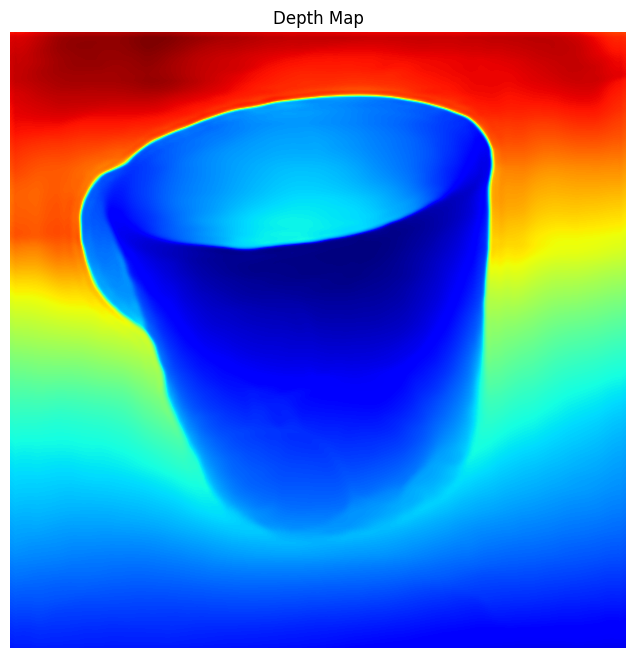

In [40]:
import matplotlib.pyplot as plt

def visualize_depth_map(depth_map):
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 8))

    # Display the depth map as an image
    ax.imshow(depth_map, cmap='jet')
    ax.set_title('Depth Map')
    ax.axis('off')

    # Show the plot
    plt.show()

visualize_depth_map(depth_col)


In [41]:
print(IMAGE_PATH)
print(mask_path)
print(output_file)

/content/input/cup.jpeg
/content/output/obj_masks/cup_seg.png
/content/output/pcd_objects/cup.obj


3D RECONSTRUCTION

In [42]:
def run_viz(model, samples, device, args, prefix):
    model.eval()

    seen_xyz, valid_seen_xyz, unseen_xyz, unseen_rgb, labels, seen_images = prepare_data(
        samples, device, is_train=False, args=args, is_viz=True
    )
    pred_occupy = []
    pred_colors = []

    max_n_unseen_fwd = 2000

    model.cached_enc_feat = None
    num_passes = int(np.ceil(unseen_xyz.shape[1] / max_n_unseen_fwd))
    for p_idx in tqdm(range(num_passes)):
        p_start = p_idx     * max_n_unseen_fwd
        p_end = (p_idx + 1) * max_n_unseen_fwd
        cur_unseen_xyz = unseen_xyz[:, p_start:p_end]
        cur_unseen_rgb = unseen_rgb[:, p_start:p_end].zero_()
        cur_labels = labels[:, p_start:p_end].zero_()

        with torch.no_grad():
            _, pred = model(
                seen_images=seen_images,
                seen_xyz=seen_xyz,
                unseen_xyz=cur_unseen_xyz,
                unseen_rgb=cur_unseen_rgb,
                unseen_occupy=cur_labels,
                cache_enc=True,
                valid_seen_xyz=valid_seen_xyz,
            )
        pred_occupy.append(pred[..., 0].cuda())
        if args.regress_color:
            pred_colors.append(pred[..., 1:].reshape((-1, 3)))
        else:
            pred_colors.append(
                (
                    torch.nn.Softmax(dim=2)(
                        pred[..., 1:].reshape((-1, 3, 256)) / args.temperature
                    ) * torch.linspace(0, 1, 256, device=pred.device)
                ).sum(axis=2)
            )
    with open(prefix + f"_{os.path.splitext(IMAGE_NAME)[0]}" +'.html', 'a') as f:
        generate_html(
            None,
            None, None,
            torch.cat(pred_occupy, dim=1),
            torch.cat(pred_colors, dim=0),
            unseen_xyz,
            f,
            gt_xyz=None,
            gt_rgb=None,
            mesh_xyz=None,
            score_thresholds=args.score_thresholds,
            pointcloud_marker_size=3,
        )

def pad_image(im, value):
    if im.shape[0] > im.shape[1]:
        diff = im.shape[0] - im.shape[1]
        return torch.cat([im, (torch.zeros((im.shape[0], diff, im.shape[2])) + value)], dim=1)
    else:
        diff = im.shape[1] - im.shape[0]
        return torch.cat([im, (torch.zeros((diff, im.shape[1], im.shape[2])) + value)], dim=0)


def normalize(seen_xyz):
    seen_xyz = seen_xyz / (seen_xyz[torch.isfinite(seen_xyz.sum(dim=-1))].var(dim=0) ** 0.5).mean()
    seen_xyz = seen_xyz - seen_xyz[torch.isfinite(seen_xyz.sum(dim=-1))].mean(axis=0)
    return seen_xyz


def main(args):

    model = mcc_model.get_mcc_model(
        occupancy_weight=1.0,
        rgb_weight=0.01,
        args=args,
    ).cuda()

    misc.load_model(args=args, model_without_ddp=model, optimizer=None, loss_scaler=None)

#     rgb = cv2.imread(args.image)
    obj = load_obj(args.point_cloud)

    seen_rgb = (torch.tensor(bgr).float() / 255)[..., [2, 1, 0]]
    H, W = seen_rgb.shape[:2]
    seen_rgb = torch.nn.functional.interpolate(
        seen_rgb.permute(2, 0, 1)[None],
        size=[H, W],
        mode="bilinear",
        align_corners=False,
    )[0].permute(1, 2, 0)

    seen_xyz = obj[0].reshape(H, W, 3)
    seg = cv2.imread(args.seg, cv2.IMREAD_UNCHANGED)
    mask = torch.tensor(cv2.resize(seg, (W, H))).bool()
    seen_xyz[~mask] = float('inf')

    seen_xyz = normalize(seen_xyz)

    bottom, right = mask.nonzero().max(dim=0)[0]
    top, left = mask.nonzero().min(dim=0)[0]

    bottom = bottom + 40
    right = right + 40
    top = max(top - 40, 0)
    left = max(left - 40, 0)

    seen_xyz = seen_xyz[top:bottom+1, left:right+1]
    seen_rgb = seen_rgb[top:bottom+1, left:right+1]

    seen_xyz = pad_image(seen_xyz, float('inf'))
    seen_rgb = pad_image(seen_rgb, 0)

    seen_rgb = torch.nn.functional.interpolate(
        seen_rgb.permute(2, 0, 1)[None],
        size=[800, 800],
        mode="bilinear",
        align_corners=False,
    )

    seen_xyz = torch.nn.functional.interpolate(
        seen_xyz.permute(2, 0, 1)[None],
        size=[112, 112],
        mode="bilinear",
        align_corners=False,
    ).permute(0, 2, 3, 1)

    samples = [
        [seen_xyz, seen_rgb],
        [torch.zeros((20000, 3)), torch.zeros((20000, 3))],
    ]
    run_viz(model, samples, "cuda", args, prefix=args.output)


In [43]:
print(IMAGE_PATH)
print(mask_path)
print(output_file)

/content/input/cup.jpeg
/content/output/obj_masks/cup_seg.png
/content/output/pcd_objects/cup.obj


In [44]:
parser = main_mcc.get_args_parser()
parser.add_argument('--image', default=IMAGE_PATH, type=str, help='input image file')
parser.add_argument('--point_cloud', default=output_file, type=str, help='input obj file')
parser.add_argument('--seg', default=mask_path, type=str, help='input obj file')
parser.add_argument('--output', default='output/3D', type=str, help='output path')
parser.add_argument('--granularity', default=0.05, type=float, help='output granularity')
parser.add_argument('--score_thresholds', default=[0.1, 0.2, 0.3, 0.4, 0.5], type=float, nargs='+', help='score thresholds')
parser.add_argument('--temperature', default=0.1, type=float, help='temperature for color prediction.')
parser.add_argument('--checkpoint', default='MCC/co3dv2_all_categories.pth', type=str, help='model checkpoint')

parser.set_defaults(eval=True)

args = parser.parse_args(args=[])
args.resume = args.checkpoint
args.viz_granularity = args.granularity

In [45]:
main(args)

Resume checkpoint MCC/co3dv2_all_categories.pth
_IncompatibleKeys(missing_keys=[], unexpected_keys=['mask_token'])


100%|██████████| 864/864 [04:56<00:00,  2.92it/s]


In [47]:
fl = f"output/3D_{os.path.splitext(IMAGE_NAME)[0]}.html"
final = os.path.join(os.getcwd(), fl)
print(final)

/content/output/3D_cup.html


In [48]:
from IPython.display import IFrame

# Specify the path to the saved HTML file
html_file = final

# Display the HTML file using IFrame
IFrame(src=html_file, width='100%', height='800px')
